# `dysh` Staff Training July 18 2024

## What will we cover this session
* [`dysh`](#dysh)
* [Importing `dysh`](#imports)
* [Getting help](#help)
* [Loading data](#loading)
* [Inspecting data](#inspecting)
   * [Total power](#tpcal)
* [Position switched calibration](#pscal)
    * [Working with integrations](#integrations)
    * [Time averaging](#time-averaging)
    * [Spectrum arithmetic](#arithmetic)
    * [Data I/O](#io)
* [Frequency switched calibration](#fscal)
    * [Using selection](#fscal-selection)
* [Subbeam nod calibration](#sbncal)

## `dysh` <a class="anchor" id="dysh"></a>

Like any data reduction package, `dysh` has its own way of storing and handling the data.
We will provide a brief overview of how `dysh` does this, focusing on GBT data.

The higher level unit is the `GBTFITSLoad` object. This loads the data and creates an index from it.

Down the hierarchy we have `ScanBlock` objects that bundle a series of `Scan` objects together.

Then we have `Scan` objects that hold the data for a single scan. There are currently four flavors: `TPScan`, `PSScan`, `FSScan` and `SubBeamNodScan`, but they all have attributes in common.

Finally, we have `Spectrum` objects. These represent a single spectrum, and are the closest thing there is in `dysh` to `GBTIDL` data containers.

Perhaphs the following will make it easier to see the hierarchy:
```Python
sdfits = GBTFITSLoad()        # GBTFITSLoad object
scan_block = sdf.getps()      # ScanBlock object
scan = scan_block[0]          # Scan object
spectrum = scan.timeaverage() # Spectrum object
```

## Importing `dysh` <a class="anchor" id="imports"></a>

When working through `dysh-lab` we have to import all the modules we want to use, including `dysh` itself. By default, the modules that are requirements for `dysh` are also available. These include `numpy`, `astropy`, `pandas`, `matplotlib` and `scipy`.

In [3]:
from astropy import units as u
from dysh.fits import GBTFITSLoad
from dysh.util.files import dysh_data

<details>
  <summary class="alert alert-block alert-info">Info</summary>
  <div class="alert alert-block alert-info" markdown=1>
In this example, we will do our best to avoid using functions and modules other than <code>dysh</code>, but it is important to note that you have all the power of <code>Python</code> and its modules available! (i.e., <code>dysh</code> is just another module.)

![Python is powerful](https://imgs.xkcd.com/comics/python.png)
</div>
</details>


## Getting help <a class="anchor" id="help"></a>

Getting help can be done like for any other `Python` package. There are three ways of getting in-line help:
```Python
help(command)
command?
command??
```

For example, to get help on the `getps` function of a `GBTFITSLoad` object one could use any of these:
```Python
help(GBTFITSLoad.getps)
GBTFITSLoad.getps?
GBTFITSLoad.getps??
```

`help()` will display the documentation for a module, function, or object, while `?` will display their documentation string (a shortened version). So, `?` is equivalent to `GBTIDL` `usage`, `help()` is equivalent to `usage,/verbose` and `??` is equivalent to `usage,/source`.

In [2]:
help(GBTFITSLoad.getps)

Help on function getps in module dysh.fits.gbtfitsload:

getps(self, calibrate=True, timeaverage=True, polaverage=False, weights='tsys', bintable=None, **kwargs)
    Retrieve and calibrate position-switched data.
    
    Parameters
    ----------
    calibrate : boolean, optional
        Calibrate the scans. The default is True.
    timeaverage : boolean, optional
        Average the scans in time. The default is True.
    polaverage : boolean, optional
        Average the scans in polarization. The default is False.
    weights : str or None, optional
        How to weight the spectral data when averaging.  'tsys' means use system
        temperature weighting (see e.g., :meth:`~spectra.scan.PSScan.timeaverage`);
        None means uniform weighting. The default is 'tsys'.
    bintable : int, optional
        Limit to the input binary table index. The default is None which means use all binary tables.
        (This keyword should eventually go away)
    **kwargs : dict
        Option

In [3]:
GBTFITSLoad.getps??

Signature:
GBTFITSLoad.getps(
    self,
    calibrate=True,
    timeaverage=True,
    polaverage=False,
    weights='tsys',
    bintable=None,
    **kwargs,
)
Source:   
    def getps(self, calibrate=True, timeaverage=True, polaverage=False, weights="tsys", bintable=None, **kwargs):
        """
        Retrieve and calibrate position-switched data.

        Parameters
        ----------
        calibrate : boolean, optional
            Calibrate the scans. The default is True.
        timeaverage : boolean, optional
            Average the scans in time. The default is True.
        polaverage : boolean, optional
            Average the scans in polarization. The default is False.
        weights : str or None, optional
            How to weight the spectral data when averaging.  'tsys' means use system
            temperature weighting (see e.g., :meth:`~spectra.scan.PSScan.timeaverage`);
            None means uniform weighting. The default is 'tsys'.
        bintable : int, optional

If the above does not provide enough help there are other things you can try. Going to the [`dysh` documentation](https://dysh.readthedocs.io/en/latest/), or asking the `dysh` development team. If all else fails, or what you want to do is not supported, you can submitting a bug or a feature request through the [`dysh` GitHub repository](https://github.com/GreenBankObservatory/dysh/issues).

## Loading data <a class="anchor" id="loading"></a>

To load data in `dysh` you have to provide the full path to a SDFITS file or to a directory containing SDFITS files. In the latter case, `dysh` will load all the files ending in .fits inside the directory.

Here we will point `dysh` to a directory containing a single SDFITS file in the `dysh` `example_data` area.

In [9]:
filename = "/home/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/"
filename = dysh_data(test="getps")
filename = dysh_data(example="getps")
sdf = GBTFITSLoad(filename)

<details>
  <summary class="alert alert-block alert-danger">Warning</summary>
  <div class="alert alert-block alert-danger" markdown=1>
If you point <code>dysh</code> to a directory containing files that end in .fits that are not SDFITS, <code>dysh</code> will still try to load them and likely fail.
</div>
</details>

## Inspecting data <a class="anchor" id="inspecting"></a>

The `GBTFITSLoad` objects have a summary method, similar to `GBTIDL`'s summary. 

<details>
  <summary class="alert alert-block alert-info">Info</summary>
  <div class="alert alert-block alert-info" markdown=1>
One difference in the summary is that <code>dysh</code> prints the average value for the "AZIMUTH" and "ELEVATIO" columns.
</div>
</details>

In [10]:
sdf.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


You can get more information by using the `verbose=True` option. In this case it is also advisable to restrict the summary to a single scan, otherwise the summary may get cut short.

In [11]:
sdf.summary(scan=52, verbose=True)

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,PROCSIZE,RESTFREQ,DOPFREQ,IFNUM,PLNUM,FDNUM,FEED,SIG,CAL,INTNUM,AZIMUTH,ELEVATIO,DATE-OBS
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,1,0,1,T,T,0,198.746073,18.840300,2005-06-27T02:08:14.00
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,1,0,1,T,F,0,198.746073,18.840300,2005-06-27T02:08:14.00
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,0,0,1,T,T,0,198.746073,18.840300,2005-06-27T02:08:14.00
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,0,0,1,T,F,0,198.746073,18.840300,2005-06-27T02:08:14.00
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,1,0,1,T,T,1,198.783080,18.829958,2005-06-27T02:08:24.09
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,1,0,1,T,F,1,198.783080,18.829958,2005-06-27T02:08:24.09
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,0,0,1,T,T,1,198.783080,18.829958,2005-06-27T02:08:24.09
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,0,0,1,T,F,1,198.783080,18.829958,2005-06-27T02:08:24.09
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,1,0,1,T,T,2,198.820028,18.819357,2005-06-27T02:08:34.19
52,NGC5291,4386.0,OnOff,2,2,1.420405,1.420405,0,1,0,1,T,F,2,198.820028,18.819357,2005-06-27T02:08:34.19


Individual rows can be accessed using the `getspec` method. The returned object is a `Spectrum`. More on those latter, but they can make plots.

KeyError: 'TSCALE'

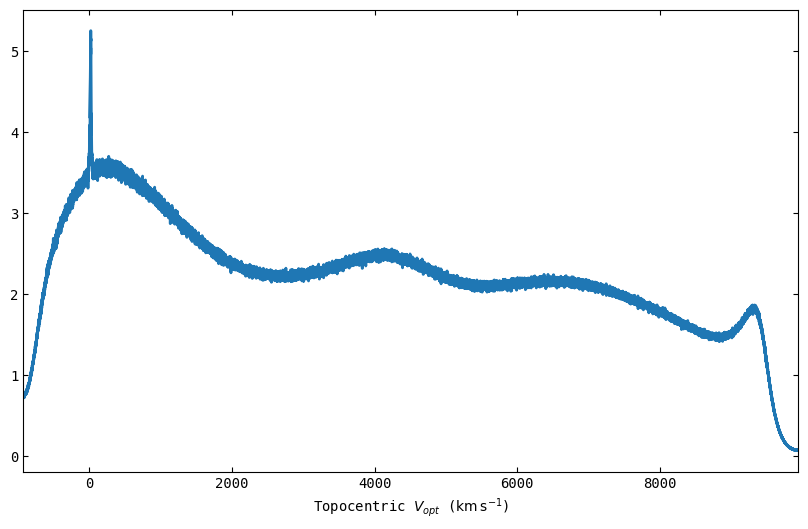

In [12]:
row = sdf.getspec(0)
row.plot(xaxis_unit="km/s", title="My first plot")

The spectrum retrieval indexing follows Python indexing rules. This data set has 351 rows, so the following are equivalent
```Python
sdf.getspec(350)
sdf.getspec(-1)
```

In [8]:
s_last_a = sdf.getspec(351)
s_last_b = sdf.getspec(-1)

print( f"Sum of all the channels in the difference: {(s_last_a - s_last_b).sum()}" )

Sum of all the channels in the difference: 0.0 ct


All the columns can be accessed using the `_index` attribute of a `GBTFITSLoad` object

In [9]:
sdf._index.columns

Index(['OBJECT', 'BANDWID', 'DATE-OBS', 'DURATION', 'EXPOSURE', 'TSYS',
       'TDIM7', 'TUNIT7', 'CTYPE1', 'CRVAL1', 'CRPIX1', 'CDELT1', 'CTYPE2',
       'CRVAL2', 'CTYPE3', 'CRVAL3', 'CRVAL4', 'OBSERVER', 'OBSID', 'SCAN',
       'OBSMODE', 'FRONTEND', 'TCAL', 'VELDEF', 'VFRAME', 'RVSYS', 'OBSFREQ',
       'LST', 'AZIMUTH', 'ELEVATIO', 'TAMBIENT', 'PRESSURE', 'HUMIDITY',
       'RESTFREQ', 'FREQRES', 'EQUINOX', 'RADESYS', 'TRGTLONG', 'TRGTLAT',
       'SAMPLER', 'FEED', 'SRFEED', 'FEEDXOFF', 'FEEDEOFF', 'SUBREF_STATE',
       'SIDEBAND', 'PROCSEQN', 'PROCSIZE', 'PROCSCAN', 'PROCTYPE', 'LASTON',
       'LASTOFF', 'TIMESTAMP', 'QD_XEL', 'QD_EL', 'QD_BAD', 'QD_METHOD',
       'VELOCITY', 'ZEROCHAN', 'DOPFREQ', 'SIG', 'CAL', 'CALTYPE', 'TWARM',
       'TCOLD', 'CALPOSITION', 'IFNUM', 'PLNUM', 'FDNUM', 'HDU', 'BINTABLE',
       'ROW', 'FITSINDEX', 'PROC', 'OBSTYPE', 'SUBOBSMODE', 'INTNUM'],
      dtype='object')

The original SDFITS file can be found under the `_sdf` attribute of a `GBTFITSLoad` object.

For example, the `"DATA"` column contains the raw data

In [10]:
sdf._sdf[0].bintable[0].data["DATA"][0]

array([0.7571491 , 0.72955656, 0.7319394 , ..., 0.07370767, 0.07049818,
       0.07600664], dtype='>f4')

The `"SCAN"` column contains the scan numbers

In [11]:
sdf._sdf[0].bintable[0].data["SCAN"]

array([51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51,
       51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52,
       52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54, 54,
       54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56,
       56, 56, 56, 56, 56

The `"TCAL"` column the temperature of the noise diode. This comes from the engineering FITS files.

In [12]:
sdf._sdf[0].bintable[0].data["TCAL"]

array([1.4242918, 1.4242918, 1.4526501, 1.4526501, 1.4242918, 1.4242918,
       1.4526501, 1.4526501, 1.4242918, 1.4242918, 1.4526501, 1.4526501,
       1.4242918, 1.4242918, 1.4526501, 1.4526501, 1.4242918, 1.4242918,
       1.4526501, 1.4526501, 1.4242918, 1.4242918, 1.4526501, 1.4526501,
       1.4242918, 1.4242918, 1.4526501, 1.4526501, 1.4242918, 1.4242918,
       1.4526501, 1.4526501, 1.4242918, 1.4242918, 1.4526501, 1.4526501,
       1.4242918, 1.4242918, 1.4526501, 1.4526501, 1.4242918, 1.4242918,
       1.4526501, 1.4526501, 1.4242917, 1.4242917, 1.45265  , 1.45265  ,
       1.4242917, 1.4242917, 1.45265  , 1.45265  , 1.4242917, 1.4242917,
       1.45265  , 1.45265  , 1.4242917, 1.4242917, 1.45265  , 1.45265  ,
       1.4242917, 1.4242917, 1.45265  , 1.45265  , 1.4242917, 1.4242917,
       1.45265  , 1.45265  , 1.4242917, 1.4242917, 1.45265  , 1.45265  ,
       1.4242917, 1.4242917, 1.45265  , 1.45265  , 1.4242917, 1.4242917,
       1.45265  , 1.45265  , 1.4242917, 1.4242917, 

## Total power <a class="anchor" id="tpcal"></a>

Total power data can be retrieved using
```Python
sdf.gettp()
```

<details>
  <summary class="alert alert-block alert-warning">Caveat</summary>
  <div class="alert alert-block alert-warning" markdown=1>
In <code>dysh0.3.0</code> <code>gettp</code> will only work if you the data has the same number of integrations with the noise diode on and off. It also does not support selection of different signal states (<code>"SIG"</code> column) or noise diode states (<code>"CAL"</code> column). The next release of <code>dysh</code> will have more options for <code>gettp</code>.
</div>
</details>



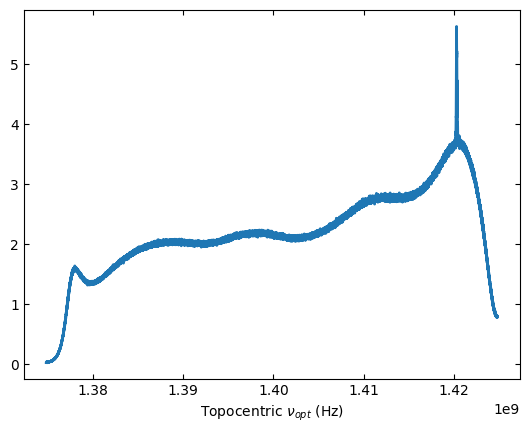

In [13]:
tp_scan = sdf.gettp(scan=51, ifnum=0, plnum=0)
tp = tp_scan[0].total_power(0)
tp.plot()

We will work with `ScanBlock`s more in the following sections. For now we will note that they have a `timeaverage` method that lets you time average the data.

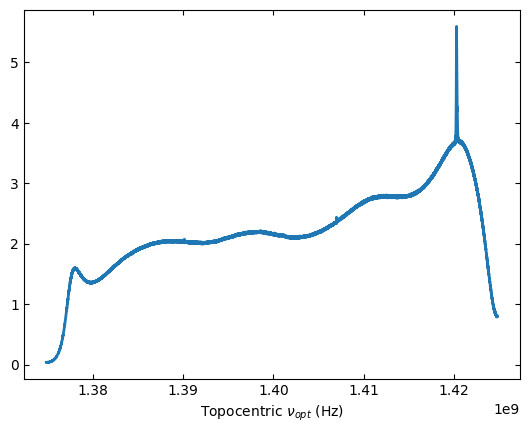

In [14]:
tp_avg = tp_scan[0].timeaverage()
tp_avg.plot()

## Position switched calibration <a class="anchor" id="pscal"></a>

We can calibrate a single position switched scan using
```Python
sdf.getps()
```
this works similarly to `GBTIDL`s `getps` altough the default values are different. `dysh` does not assume a default scan, ifnum or plnum. This can be useful and dangerous.

For now, we will calibrate a single scan, 52, only one IF and polarization.

In [15]:
ps_scan = sdf.getps(scan=52, ifnum=0, plnum=0)

Now, `ps_scan` contains a `ScanBlock` object that can hold multiple `Scan` objects. Each `Scan` holds the calibrated data, for each integration, along with other quantities. Some useful attributes are
```Python
Scan.nrows
Scan.scan
Scan.nchan
```

In [16]:
print(f"""Scan {ps_scan[0].scan} has """
      f"""{ps_scan[0].nrows} rows and each row has {ps_scan[0].nchan} channels"""
     )

Scan 51 has 22 rows and each row has 32768 channels


### Working with integrations <a class="anchor" id="integrations"></a>

To inspect the data for an integration we can use
```Python
ps_scan[0].calibrated(0)
```
which will return a `Spectrum` object. `Spectrum` objects have the full metadata from the integration, as well as WCS information. Besides plotting, they also enable computing statistics and baseline fit/removal.

mean: 0.28 K rms: 0.26 min: -3.23 K max2.96 K


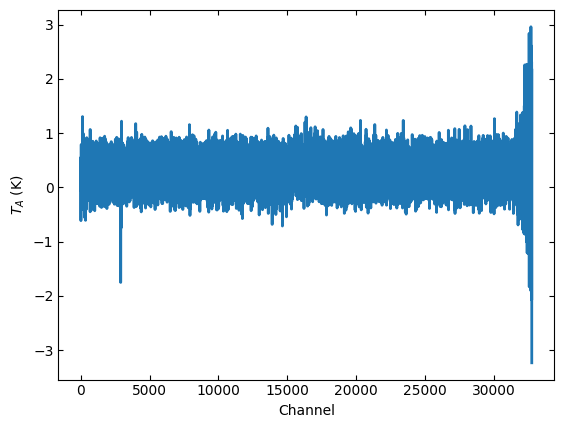

EXCLUDING [Spectral Region, 1 sub-regions:
  (1417187443.5898438 Hz, 1424816838.1210938 Hz) 
, Spectral Region, 1 sub-regions:
  (1374818364.0 Hz, 1379040470.9335938 Hz) 
]


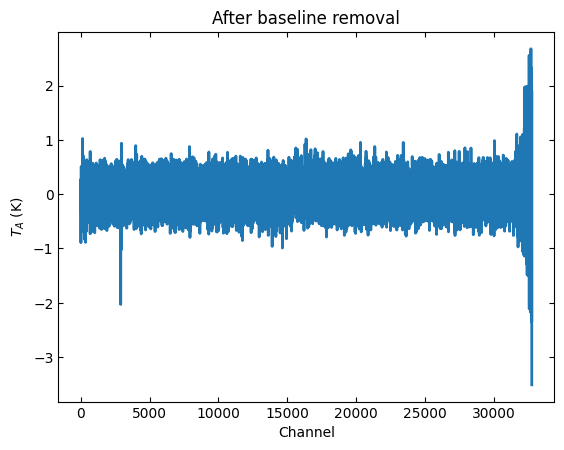

In [17]:
ta_int = ps_scan[0].calibrated(0)

# Get statistics.
print("mean: {:.2f} rms: {:.2f} min: {:.2f} max{:.2f}".format(*ta_int.stats()))

# Plot.
ta_int.plot(xaxis_unit="channel")

# Remove a baseline.
ta_int.baseline(include=[(5000,30000)], degree=0, remove=True)
ta_int.plot(xaxis_unit="channel", title="After baseline removal")

We can also inspect some of the metadata, like the system temperature for each integration.

In [18]:
ps_scan[0].tsys

array([19.20120104, 19.6092586 , 19.15375362, 19.5747285 , 19.41974068,
       19.58266944, 19.19041144, 19.19037715, 19.15063735, 19.22758217,
       19.62405922])

### Time averaging <a class="anchor" id="time-averaging"></a>

We can also take the time average, which returns another `Spectrum` object. By default each integration is weighted by 
$$ \frac{\Delta t \Delta\nu}{T_{\rm{sys}}^{2}} $$

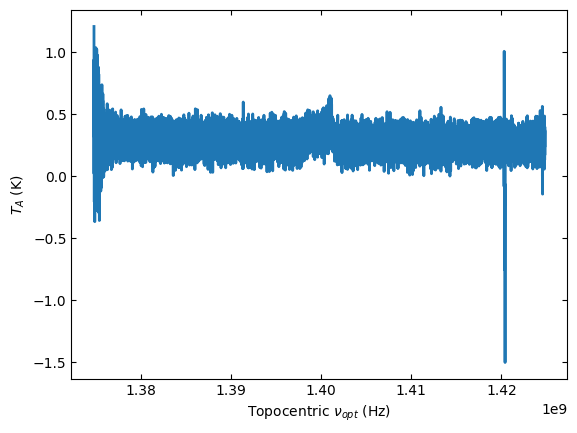

In [19]:
ta_avg = ps_scan[0].timeaverage()

ta_avg.plot()

`dysh` also enables the calibration of more than one scan at once. For this data set, all of the scans are _OnOff_, so if we omit the scan argument, `dysh` will try to calibrate all of the scans in the loaded data.

Be careful though, if you do not specify an IF dysh will grab all of them.

Number of OnOff scan pairs: 4


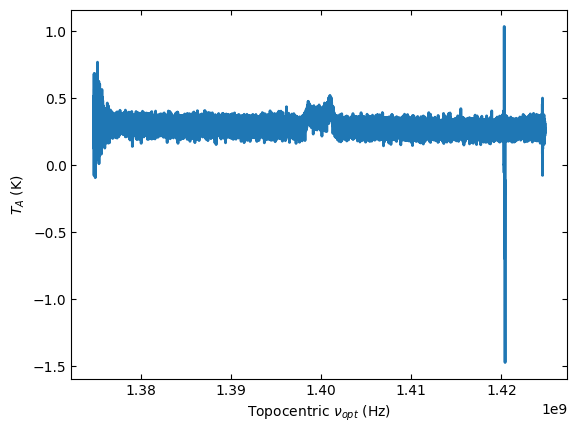

In [20]:
ps_scans = sdf.getps(ifnum=0, plnum=0)
print(f"Number of OnOff scan pairs: {len(ps_scans)}")

ta_avg_all = ps_scans.timeaverage()

ta_avg_all.plot()

We can compare the noise in both time averages, however, the `Spectrum.stats` method still does not support channel selection, so it can be dominated by the noise at the edges of the IF. To avoid this we can compute the statistics by accessing the `flux` attribute of the `Spectrum` objects.

In [21]:
# Define a slice in frequency units where we will compute the noise.
s = slice(1.38*u.GHz, 1.39*u.GHz)

# Compute the noise in both `Spectrum`s.
rms_avg = ta_avg[s].flux.to('mK').std()
rms_all = ta_avg_all[s].flux.to('mK').std()

# Print the results.
print(f"rms in one scan {rms_avg:.0f} rms in all scans {rms_all:.0f}")

rms in one scan 72 mK rms in all scans 36 mK


The noise goes down as expected, from 72 mK to 36 mK.

### Spectrum arithmetic <a class="anchor" id="arithmetic"></a>

So far we have been working with only one polarization. We can calibrate and time average the second polarization and then average both polarizations as well.

In [22]:
ps_scans_pl1 = sdf.getps(ifnum=0, plnum=1)

ta_avg_all_pl1 = ps_scans_pl1.timeaverage()

# Average the `Spectrum` for both polarizations.
# ta_avg_pls = 0.5*(ta_avg_all_pl1 + ta_avg_all)
ta_avg_pls = ta_avg_all.average(ta_avg_all_pl1)

rms_pls = ta_avg_pls[s].flux.to('mK').std()

print(f"The noise now goes down by a factor of: {rms_all/rms_pls:.2f}")

The noise now goes down by a factor of: 1.40


That is close to the expected $\sqrt{2}$ improvement.

The polarization average is also a `Spectrum` object, so we can also remove a baseline and plot it.

EXCLUDING [Spectral Region, 1 sub-regions:
  (1417187318.5898438 Hz, 1424816713.1210938 Hz) 
, Spectral Region, 1 sub-regions:
  (1374818239.0 Hz, 1379040345.9335938 Hz) 
]


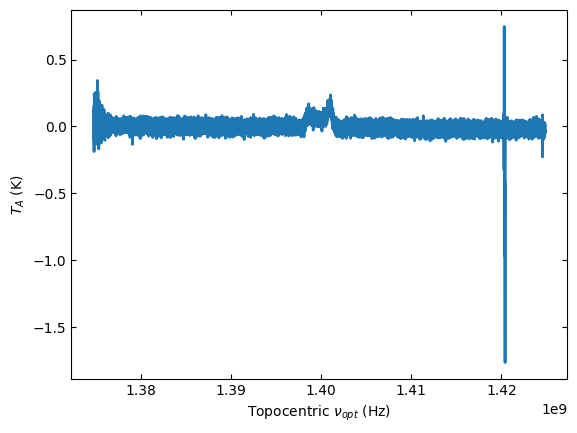

In [23]:
ta_avg_pls.baseline(include=[(5000,30000)], degree=0, remove=True)
ta_avg_pls.plot()

If the baseline fit does not look good it can be undone

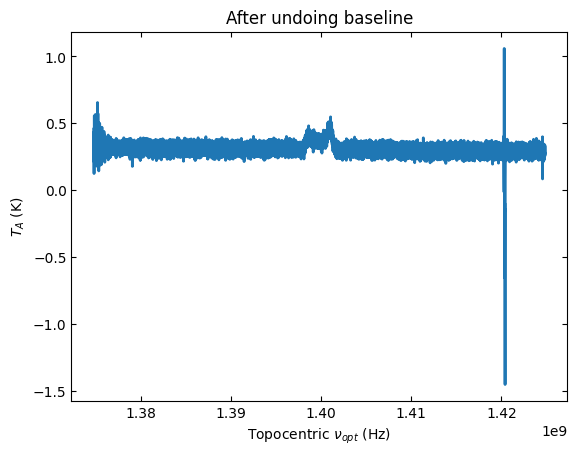

EXCLUDING [Spectral Region, 1 sub-regions:
  (1417187318.5898438 Hz, 1424816713.1210938 Hz) 
, Spectral Region, 1 sub-regions:
  (1374818239.0 Hz, 1379040345.9335938 Hz) 
]


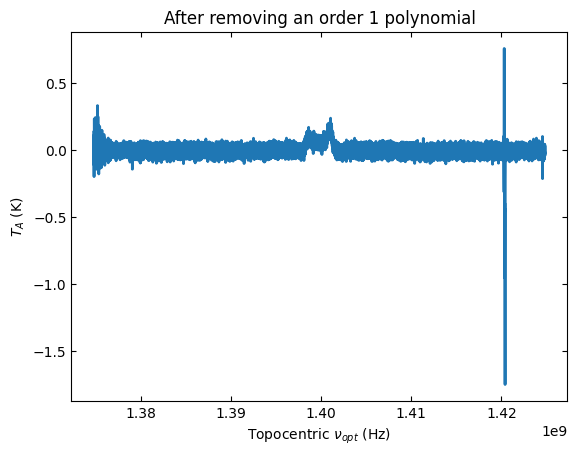

In [24]:
ta_avg_pls.undo_baseline()
ta_avg_pls.plot(title="After undoing baseline")
ta_avg_pls.baseline(include=[(5000,30000)], degree=1, remove=True)
ta_avg_pls.plot(title="After removing an order 1 polynomial")

### Data I/O <a class="anchor" id="io"></a>

This version of `dysh` has some basic I/O features that we can use to save the calibrated data. In this example we will save the data to a text file.

In [25]:
ta_avg_pls.write("position_switched.txt", format="ascii.basic", overwrite=True)

The latest version of `dysh`, to be released around December of this year, includes more formats as well as more informative column names and metadata.

## Frequency switched calibration <a class="anchor" id="fscal"></a>

Now we move to frequency switching. We will have to load a different data set for this part of the exercise. This also shows that you can load multiple data sets in the same `dysh` session.

Calibrating frequency switched observations can be done using:
```Python
sdf.getfs()
```

We start by loading a data set containing frequency switched observations and then printing a summary.

In [26]:
filename = "/home/dysh/example_data/frequencyswitch/data/TREG_050627/TREG_050627.raw.acs/"
filename = dysh_data(example="getfs2")
sdf_fs = GBTFITSLoad(filename)
sdf_fs.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,90,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.22828,18.114536
1,91,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.352097,18.20982
2,92,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.473876,18.304346
3,93,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.595308,18.399341
4,94,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.716326,18.494854


### Using selection <a class="anchor" id="fscal-selection"></a>

For this calibration we will use selection. This can be used to downselect data in a `GBTFITSLoad` object. The selection can be made on any of the columns in the SDFITS file.

To select data we use:
```Python
sdf.select()
```

We will select scan 91 of the data and then calibrate it.

In [27]:
sdf_fs.select(scan=91, tag="scan 91")

Using the `select` method then creates a `selection` attribute that contains a `Selection` object. We can inspect the `Selection` using:
```Python
sdf.selection.show()
```

In [28]:
sdf_fs.selection.show()

 ID   TAG   SCAN # SELECTED
--- ------- ---- ----------
  0 scan 91   91         48


In [29]:
fs_scan = sdf_fs.getfs(ifnum=0, plnum=0)

Just like for `getps` the return is a `ScanBlock`, but now it contains a `FSScan` object.
This `FSScan` also has similar attributes as the `PSScan` we used earlier.

In [30]:
print(f"""Scan {fs_scan[0].scan} has """
      f"""{fs_scan[0].nrows} rows and each row has {fs_scan[0].nchan} channels"""
     )

Scan 91 has 12 rows and each row has 32768 channels


We can access the calibrated data for individual integrations like before

mean: 0.08 K rms: 4.13 min: -13.24 K max: 354.39 K


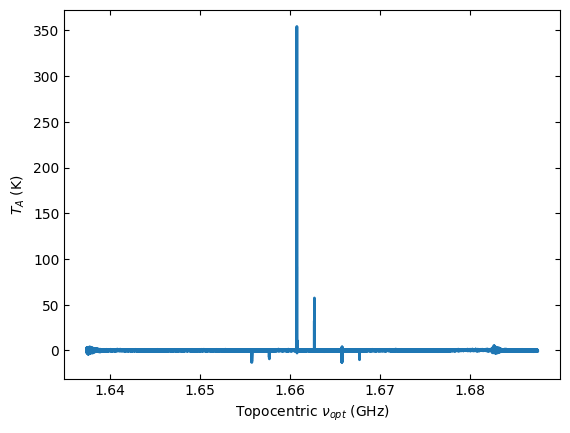

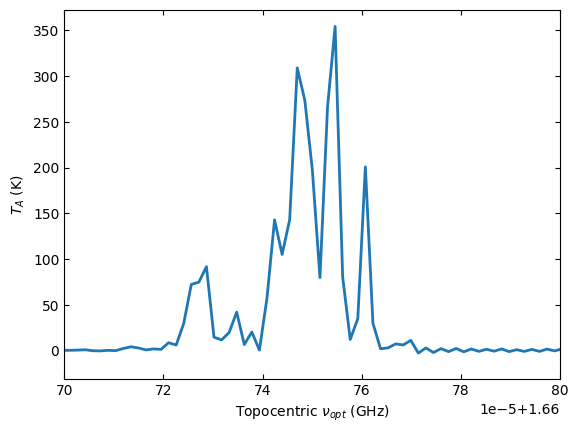

In [31]:
ta_int_fs = fs_scan[0].calibrated(0)

print("mean: {:.2f} rms: {:.2f} min: {:.2f} max: {:.2f}".format(*ta_int_fs.stats()))

ta_int_fs.plot(xaxis_unit="GHz")

# We can zoom into the bright OH line.
# The values for `xmin` and `xmax` are in the same units as `xaxis_unit`.
ta_int_fs.plot(xaxis_unit="GHz", xmin=1.6607, xmax=1.6608)

We can also skip the folding step.

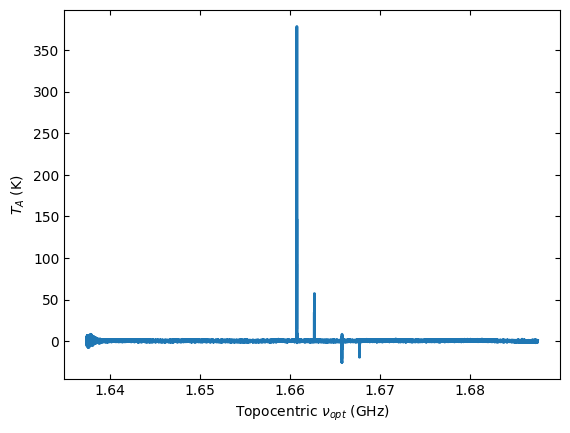

mean: 0.51 K rms: 4.26 min: -25.53 K max: 378.31 K


In [32]:
fs_scan_nofold = sdf_fs.getfs(ifnum=0, plnum=0, fold=False)
ta_int_fs_nofold = fs_scan_nofold[0].calibrated(0)
ta_int_fs_nofold.plot(xaxis_unit="GHz")
print("mean: {:.2f} rms: {:.2f} min: {:.2f} max: {:.2f}".format(*ta_int_fs_nofold.stats()))

In [33]:
s_fs = slice(1.645*u.GHz, 1.65*u.GHz)
rms_fs_int = ta_int_fs[s_fs].flux.std()
rms_fs_int_nofold = ta_int_fs_nofold[s_fs].flux.std()
print(f"rms with folding: {rms_fs_int:.2f} \nrms without folding {rms_fs_int_nofold:.2f}")
print(f"rms ratio (no_fold/fold): {rms_fs_int_nofold/rms_fs_int}")

rms with folding: 0.35 K 
rms without folding 0.51 K
rms ratio (no_fold/fold): 1.469103230215577


The ratio of the rms is close to $\sqrt2$ as expected.

Lets time average the calibrate data for this scan and inspect the result.

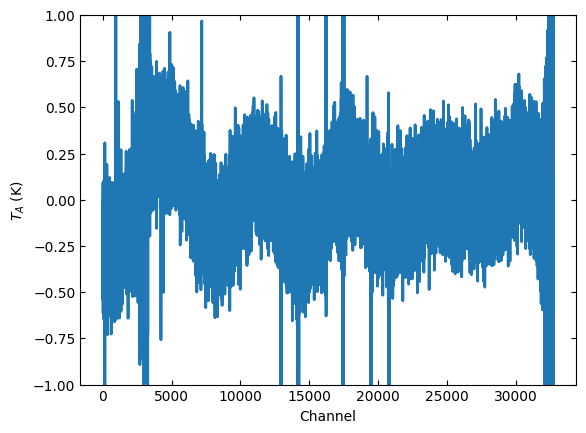

In [34]:
ta_fs_scan = fs_scan[0].timeaverage()

ta_fs_scan.plot(xaxis_unit="channel", ymin=-1, ymax=1)

There's an obvious baseline ripple. Let's try to fit it while avoiding all the spectral lines and their ghosts.

In the future, it will be possible to select regions interactively.

EXCLUDING [Spectral Region, 1 sub-regions:
  (1682112344.9492188 Hz, 1683638223.8554688 Hz) 
, Spectral Region, 1 sub-regions:
  (1667616495.3398438 Hz, 1668379434.7929688 Hz) 
, Spectral Region, 1 sub-regions:
  (1664564737.5273438 Hz, 1666090616.4335938 Hz) 
, Spectral Region, 1 sub-regions:
  (1659987100.8085938 Hz, 1663038858.6210938 Hz) 
, Spectral Region, 1 sub-regions:
  (1656935342.9960938 Hz, 1658461221.9023438 Hz) 
, Spectral Region, 1 sub-regions:
  (1654646524.6367188 Hz, 1656172403.5429688 Hz) 
]


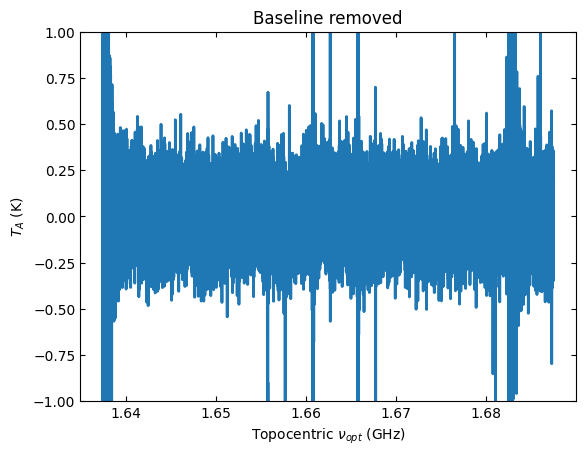

In [35]:
include = [(0,2500),(3500,12500),(13000,14000),(15000,16000),(18000,19000),(20000,20500),(21500,32000)]
ta_fs_scan.baseline(include=include, 
                    degree=17, model="chebyshev", remove=True)
ta_fs_scan.plot(xaxis_unit="GHz", ymin=-1, ymax=1, title="Baseline removed")

Unfortunately, at this point there's no built in way of displaying the baseline model. It will be possible in the future. If you want to display the baseline model you could use
```Python
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ta_fs_scan.spectral_axis, ta_fs_scan.flux)
plt.plot(ta_fs_scan.spectral_axis, ta_fs_scan._baseline_model(ta_fs_scan.spectral_axis))
plt.ylim(-1,1);
```

For frequency switching we can also calibrate all of the scans at once by using the appropriate scan selection. First, we remove the selection we made earlier using:
```Python
sdf.selection.remove()
```

In [36]:
sdf_fs.selection.remove(tag="scan 91")

For this data set all of the scans use frequency switching, so we can ignore the scan argument.

Number of FS scans: 5


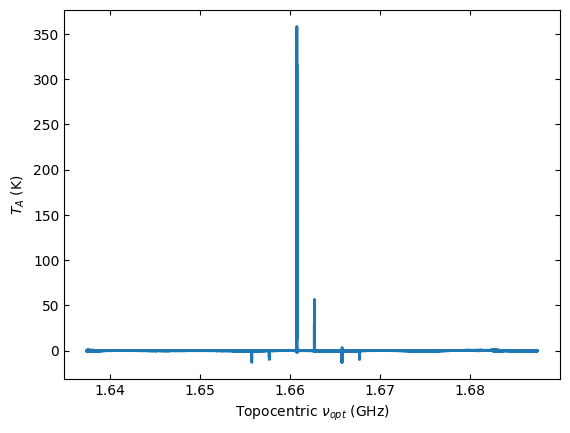

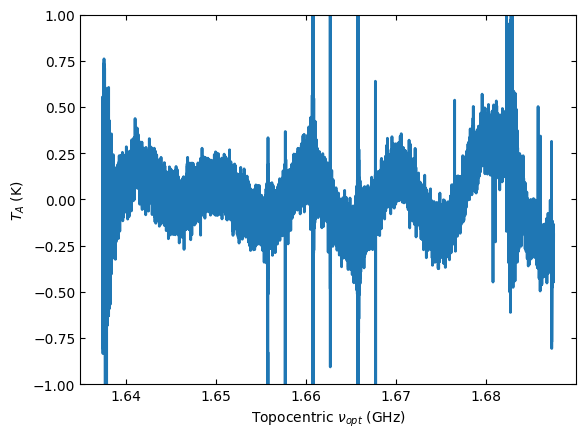

In [37]:
fs_scans = sdf_fs.getfs(ifnum=0, plnum=0)
print(f"Number of FS scans: {len(fs_scans)}")

ta_fs_avg = fs_scans.timeaverage()
ta_fs_avg.plot(xaxis_unit="GHz")

ta_fs_avg.plot(xaxis_unit="GHz", ymin=-1, ymax=1)

Again, that ugly baseline ripple. Let's remove it and compare the results with those from a single scan.

EXCLUDING [Spectral Region, 1 sub-regions:
  (1682112338.9492188 Hz, 1683638217.8554688 Hz) 
, Spectral Region, 1 sub-regions:
  (1667616489.3398438 Hz, 1668379428.7929688 Hz) 
, Spectral Region, 1 sub-regions:
  (1664564731.5273438 Hz, 1666090610.4335938 Hz) 
, Spectral Region, 1 sub-regions:
  (1659987094.8085938 Hz, 1663038852.6210938 Hz) 
, Spectral Region, 1 sub-regions:
  (1656935336.9960938 Hz, 1658461215.9023438 Hz) 
, Spectral Region, 1 sub-regions:
  (1654646518.6367188 Hz, 1656172397.5429688 Hz) 
]


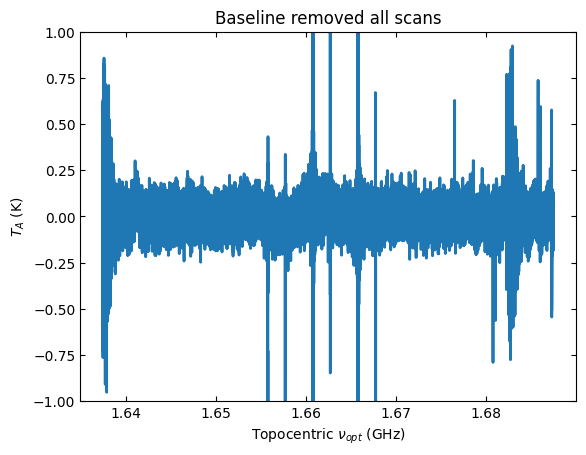

rms in a single scan: 0.145 K 
rms in all scans: 0.069 K
rms ratio: 2.102


In [38]:
ta_fs_avg.baseline(include=include, 
                    degree=17, model="chebyshev", remove=True)
ta_fs_avg.plot(xaxis_unit="GHz", ymin=-1, ymax=1, title="Baseline removed all scans")

print(f"rms in a single scan: {ta_fs_scan[s_fs].flux.std():.3f} \n"
f"rms in all scans: {ta_fs_avg[s_fs].flux.std():.3f}\n"
f"rms ratio: {ta_fs_scan[s_fs].flux.std()/ta_fs_avg[s_fs].flux.std():.3f}")

This is close enough to the $\sqrt5$ improvement expected. A better result could be obtained by modifying the baseline model and the region used for computing the statistics.

## Subbeam nod calibration <a class="anchor" id="sbncal"></a>

Now we will calibrate some data observed while wobbling the subreflector.

In [39]:
filename = "/home/dysh/example_data/subbeamnod/data/AGBT13A_124_06/AGBT13A_124_06.raw.acs/"
sdf_sbn = GBTFITSLoad(filename)
sdf_sbn.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,44,vIIzw31,16090.0,SubBeamNod,1,48.940955,48.990955,2,2,100,2,353.896698,47.758182


This data set contains a single scan of vIIzw31. To calibrate it we can use:
```Python
sdf.subbeamnod()
```

In [40]:
sbn_scan = sdf_sbn.subbeamnod(ifnum=0, plnum=0)

Like in the previous cases, the return is a `ScanBlock` that contains `SubBeamNodScan` objects (in this case only one). It has similar methods as before.

Scan 44 rows have 2048 channels


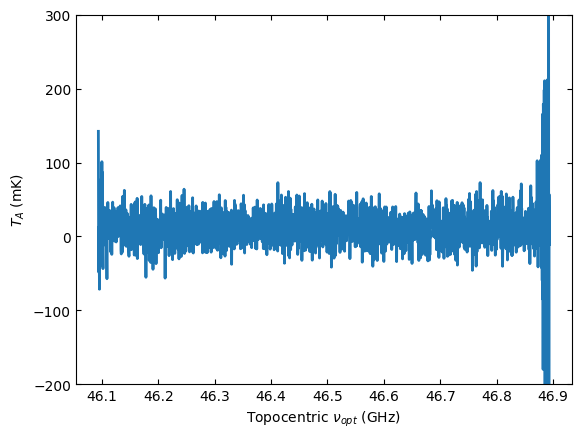

In [41]:
print(f"""Scan {sbn_scan[0].scan} """
      f"""rows have {sbn_scan[0].nchan} channels"""
     )

ta_sbn = sbn_scan.timeaverage()

ta_sbn.plot(xaxis_unit="GHz", yaxis_unit="mK", ymin=-200, ymax=300)

For subbeam nod scans, the default calibration is to treat each cycle of the scan as a position switched observation (`method="cycle"`). This uses a different system temperature for each cycle. There's an alternative, that is to average the system temperature from the off source integrations and use this single value (`method="scan"`).

In [42]:
ta_sbn_scan = sdf_sbn.subbeamnod(ifnum=0, plnum=0, method="scan").timeaverage()

We can compare the two methods as we've done previously.

In [43]:
s_sbn = slice(46.2*u.GHz, 46.5*u.GHz)

print(f"rms using method='cycle': {ta_sbn[s_sbn].flux.std():.3f}")
print(f"rms using method='scan': {ta_sbn_scan[s_sbn].flux.std():.3f}") 

rms using method='cycle': 0.019 K
rms using method='scan': 0.026 K


The `Spectrum` objects contain all of the metadata.

In [44]:
ta_sbn_scan.meta

{'OBJECT': 'vIIzw31',
 'BANDWID': 800000000.0,
 'DATE-OBS': '2014-01-30T03:34:31.00',
 'DURATION': 0.7495,
 'EXPOSURE': 2456688.0,
 'TSYS': 74.33093469359694,
 'TDIM7': '(2048,1,1,1)',
 'TUNIT7': 'Counts',
 'CTYPE1': 'FREQ-OBS',
 'CRVAL1': 46493352091.0,
 'CRPIX1': 1025.0,
 'CDELT1': -390625.0,
 'CTYPE2': 'RA',
 'CRVAL2': 79.15397217101241,
 'CTYPE3': 'DEC',
 'CRVAL3': 79.6662288267065,
 'CRVAL4': -2,
 'OBSERVER': 'Yu Gao',
 'OBSID': 'unknown',
 'SCAN': 44,
 'OBSMODE': 'SubBeamNod:NONE:TPWCAL',
 'FRONTEND': 'Rcvr40_52',
 'TCAL': 6.9513936042785645,
 'VELDEF': 'OPTI-BAR',
 'VFRAME': 11451.769356529883,
 'RVSYS': 15670231.02142068,
 'OBSFREQ': 46493352091.0,
 'LST': 24742.503308949505,
 'AZIMUTH': 353.94910590955004,
 'ELEVATIO': 47.78083849968408,
 'TAMBIENT': 251.84999999999997,
 'PRESSURE': 696.979269496545,
 'HUMIDITY': 0.712,
 'RESTFREQ': 48990955000.0,
 'FREQRES': 472656.25,
 'EQUINOX': 2000.0,
 'RADESYS': 'FK5',
 'TRGTLONG': 79.19333333333333,
 'TRGTLAT': 79.67,
 'SAMPLER': 'A1',


In [45]:
sbn_scan[0].tsys

array([78.05430586, 75.58409557, 75.54365401, 78.03553274, 75.53891095,
       75.79365405, 77.93250486, 75.27496964, 75.68244661, 77.71640702,
       76.76127442, 73.37318653, 72.91489325, 76.35407674, 73.18862705,
       73.27629742, 76.6998927 , 73.28848865, 73.23689071, 76.61313982])